In [1]:
import cv2

In [2]:
%matplotlib inline

In [30]:
test_img1 = cv2.imread('/home/sam/data/airwatergas/bradenhead_test_tif_files/05-067-09432_2606634__2532908___2009-08-27.tif', 0)
test_img2 = cv2.imread('/home/sam/data/airwatergas/bradenhead_test_tif_files/05-067-08118_401052893__3660535___2015-08-07.tif', 0)
test_img3 = cv2.imread('/home/sam/data/airwatergas/bradenhead_test_tif_files/05-067-06832_400722529__3469123___2014-10-27.tif', 0)

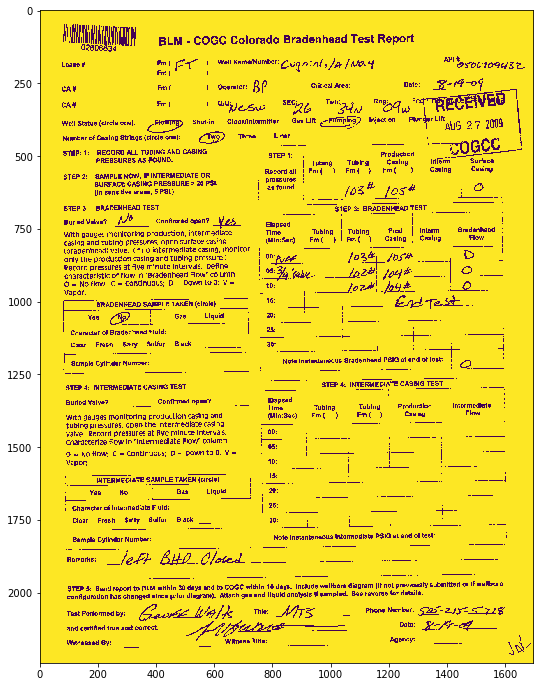

In [33]:
plt.figure(figsize=(10, 12))
plt.imshow(test_img1)

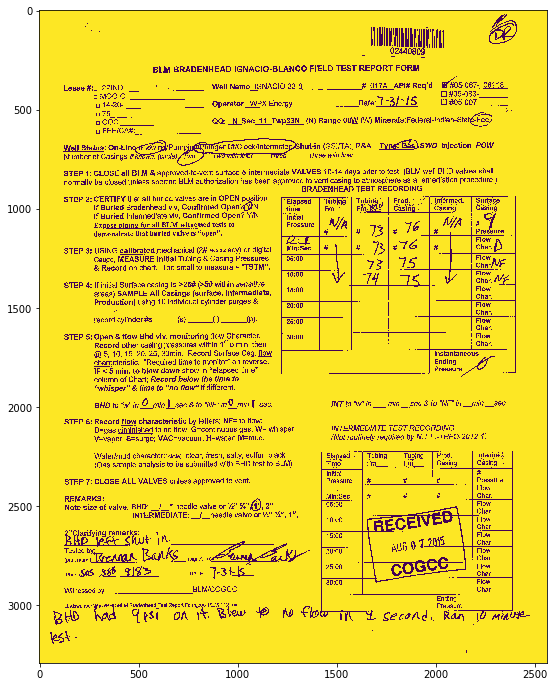

In [32]:
plt.figure(figsize=(10, 12))
plt.imshow(test_img2)

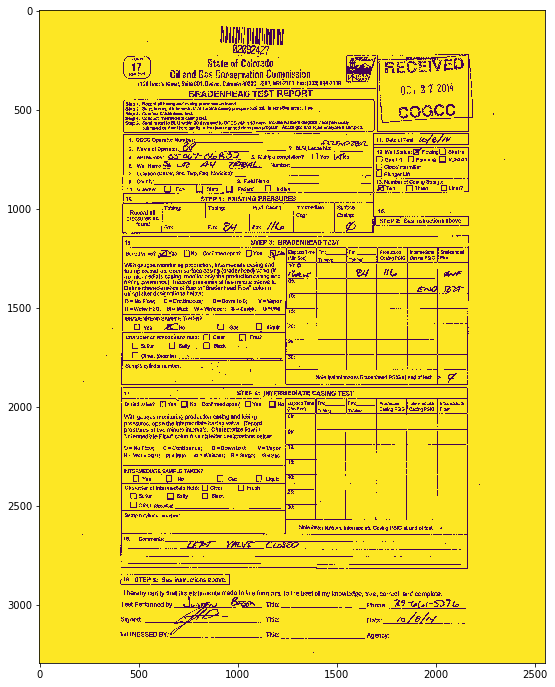

In [31]:
plt.figure(figsize=(10, 12))
plt.imshow(test_img3)

# Clustering!

Not having very much background in image processing, I was very happy to come across a package that does something I like -- locality-sensitive hashing. In this case, the `imagehash` library provides a few different hash functions, and a bit of trial and error (which I've judiciously deleted from this notebook) shows that the Haar Wavelet hashing performs the best. That corresponds with the basic approaches I read about online for creating a similarity metric for images as well.

Then once we have a LSH matrix (of non-normalized similarities), we create an affinity matrix from that and feed it into a spectral clustering algorithm. I decided on the spectral clustering algorithm somewhat arbitrarily -- but partly because I was intuitively yearning for something PCA-like to do the clustering. There were only a few other options for clustering starting with a similarity matrix implemented in scikit-learn, and if you have a better suggestion or ideas about tuning the parameters I'd like to hear it.

In [1]:
import os
import imagehash
from PIL import Image

In [23]:
import subprocess

def is_valid_tiff(path):
    return subprocess.call(['python', 'check_valid_image.py', path]) == 0

It drove me kind of crazy but there are a few malformed `tif` files that actually causes a C library that PIL depends on to crash. Since you can't catch C exceptions from Python, I figured it was good enough to write a very thin wrapper to trigger the crash, then check if it crashes for each file.

We also need to exclude non-tifs, of which there are a couple.

In [24]:
paths = []
bad = []

for i, sd in enumerate(os.scandir('/home/sam/data/airwatergas/bradenhead_test_tif_files/')):
    if i % 300 == 0:
        print('.', end='')
    
    if sd.path.endswith('.tif'):
        if is_valid_tiff(sd.path):
            paths.append(sd.path)
        else:
            bad.append(sd.path)
            print('x', end='')
    else:
        pass

.....x.x.x.xxx.x..x..xx...x..x.x..x.x.x.xxxx.x..xx.x...x.x.x.xx.

In [25]:
len(bad)

29

We move these broken files outside of the working directory.

In [30]:
import os

for path in bad:
    directory, fn = os.path.split(path)
    dest = os.path.join(directory, '..', 'broken-{}'.format(fn))
    os.rename(path, dest)

In [34]:
def hash_image(path):
    try:
        with Image.open(path) as image:
            return imagehash.whash(image)
    except OSError:
        print('Error: ', path)

In [35]:
from multiprocessing import Pool
import pickle
p = Pool(8)
hashes = p.map(hash_image, paths)

In [38]:
with open('results/image-hashes.p', 'wb') as out:
    pickle.dump(list(zip(paths, hashes)), out)

In [39]:
i_s = []
j_s = []
distances = []
for i, h1 in enumerate(hashes):
    if i % 300 == 0:
        print('.', end='')
    for j, h2 in enumerate(hashes):
        i_s.append(i)
        j_s.append(j)
        distances.append(h1 - h2)

...................................

In [41]:
import scipy
import scipy.sparse

matrix = scipy.sparse.coo_matrix((distances, (i_s, j_s)))

delta = 100

affinity_matrix = np.exp( - matrix.toarray() ** 2 / (2. * delta ** 2))

In [42]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=3, affinity='precomputed')

In [43]:
clusters = spectral.fit_predict(affinity_matrix)

In [44]:
clusters[:20]

array([2, 0, 2, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 2], dtype=int32)

In [ ]:
import pandas as pd

names = [os.path.split(p)[1] for p in paths]

In [53]:
df = pd.DataFrame(list(zip(names, clusters)), columns=['file', 'cluster'])
df.head()

,file,cluster
0,05-067-06751_1631322__2202339___2009-09-10.tif,2
1,05-067-06025_17777863__2047979___2007-11-16.tif,0
2,05-067-06285_1631396__2202269___2009-10-15.tif,2
3,05-067-05384_2524903__2672655___2010-10-28.tif,0
4,05-067-05439_400733233__3459583___2011-12-22.tif,0


In [55]:
df.sample(10)

,file,cluster
1514,05-067-08305_2447341__2862562___2011-11-16.tif,0
10234,05-067-05008_1793555__2061865___2009-04-27.tif,1
2153,05-067-09198_2222604__2867817___2011-11-14.tif,0
5785,05-007-06122_1701604__2040416___2008-11-20.tif,1
4669,05-067-08707_400973792__3611531___2015-05-18.tif,1
7976,05-071-07884_400787739__3501131___2014-08-15.tif,1
8096,05-071-09307_2514199__2920323___2012-05-11.tif,1
773,05-067-05578_17777530__2044168___2008-07-23.tif,0
5953,05-071-06921_2447917__2876375___2012-01-20.tif,1
7316,05-067-08926_401160177__3908478___2016-07-15.tif,0


In [54]:
df.to_csv('results/clusters.csv', index=False)

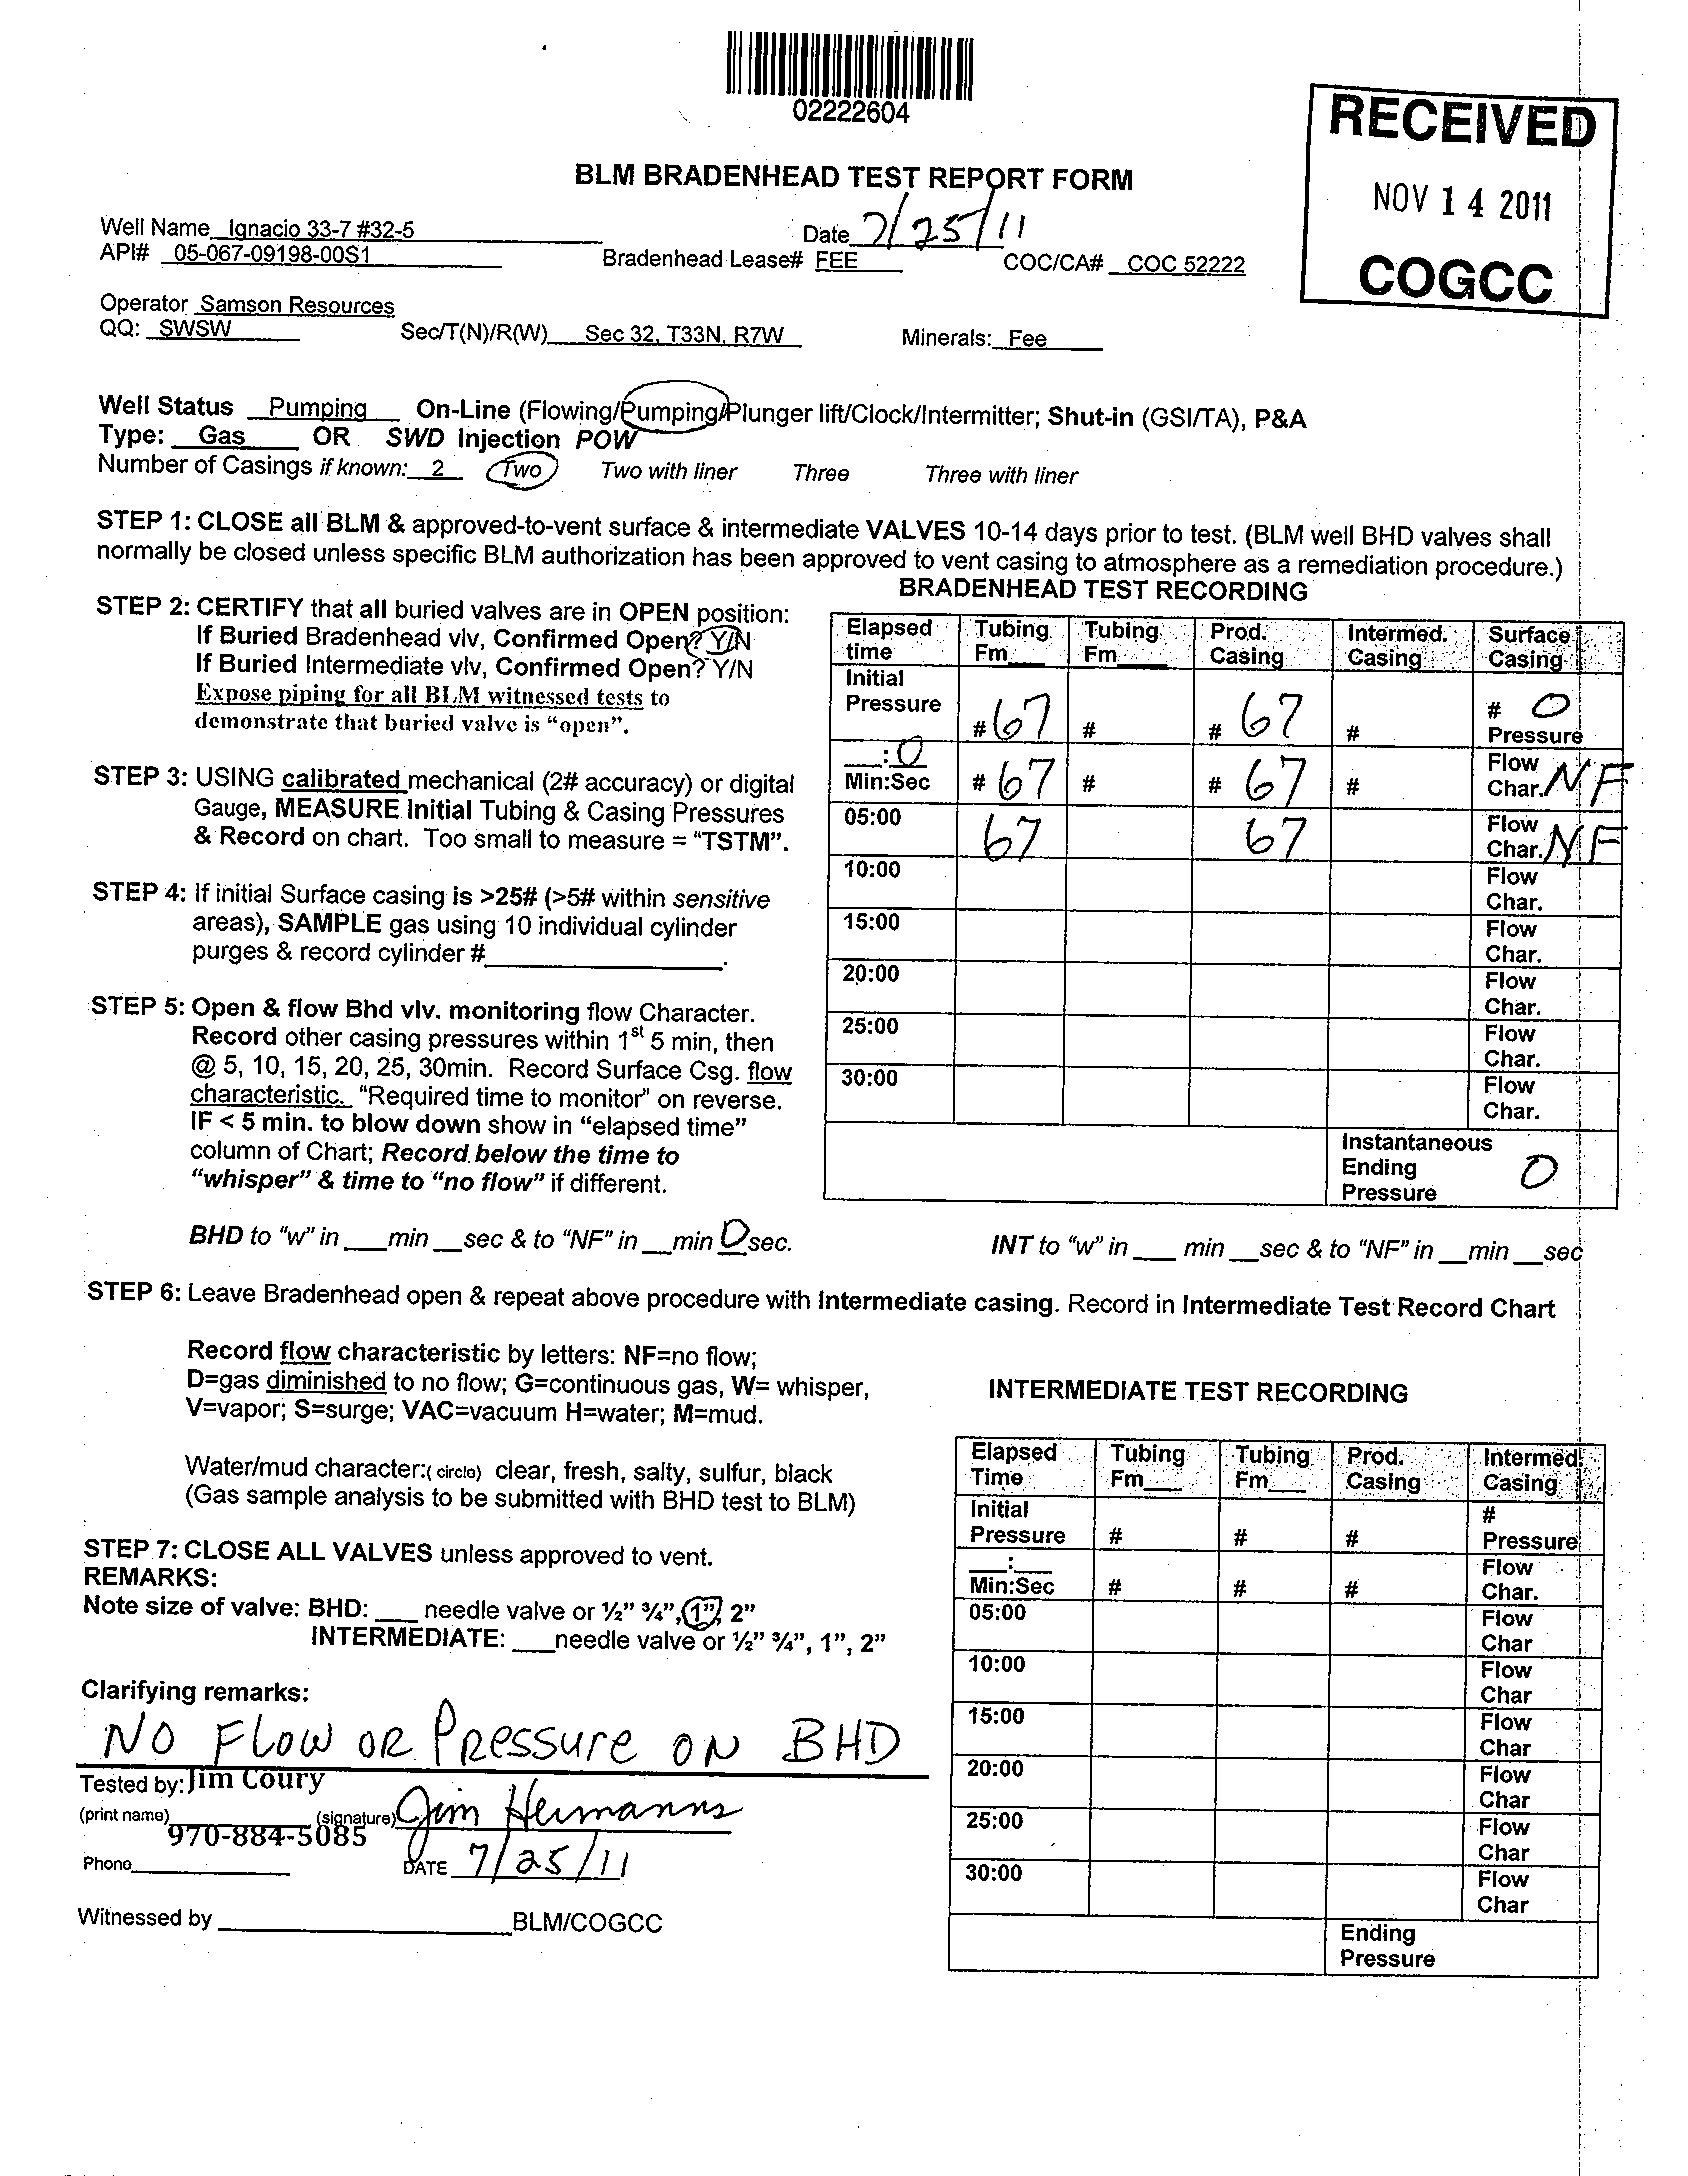

In [58]:
Image.open(paths[2153])

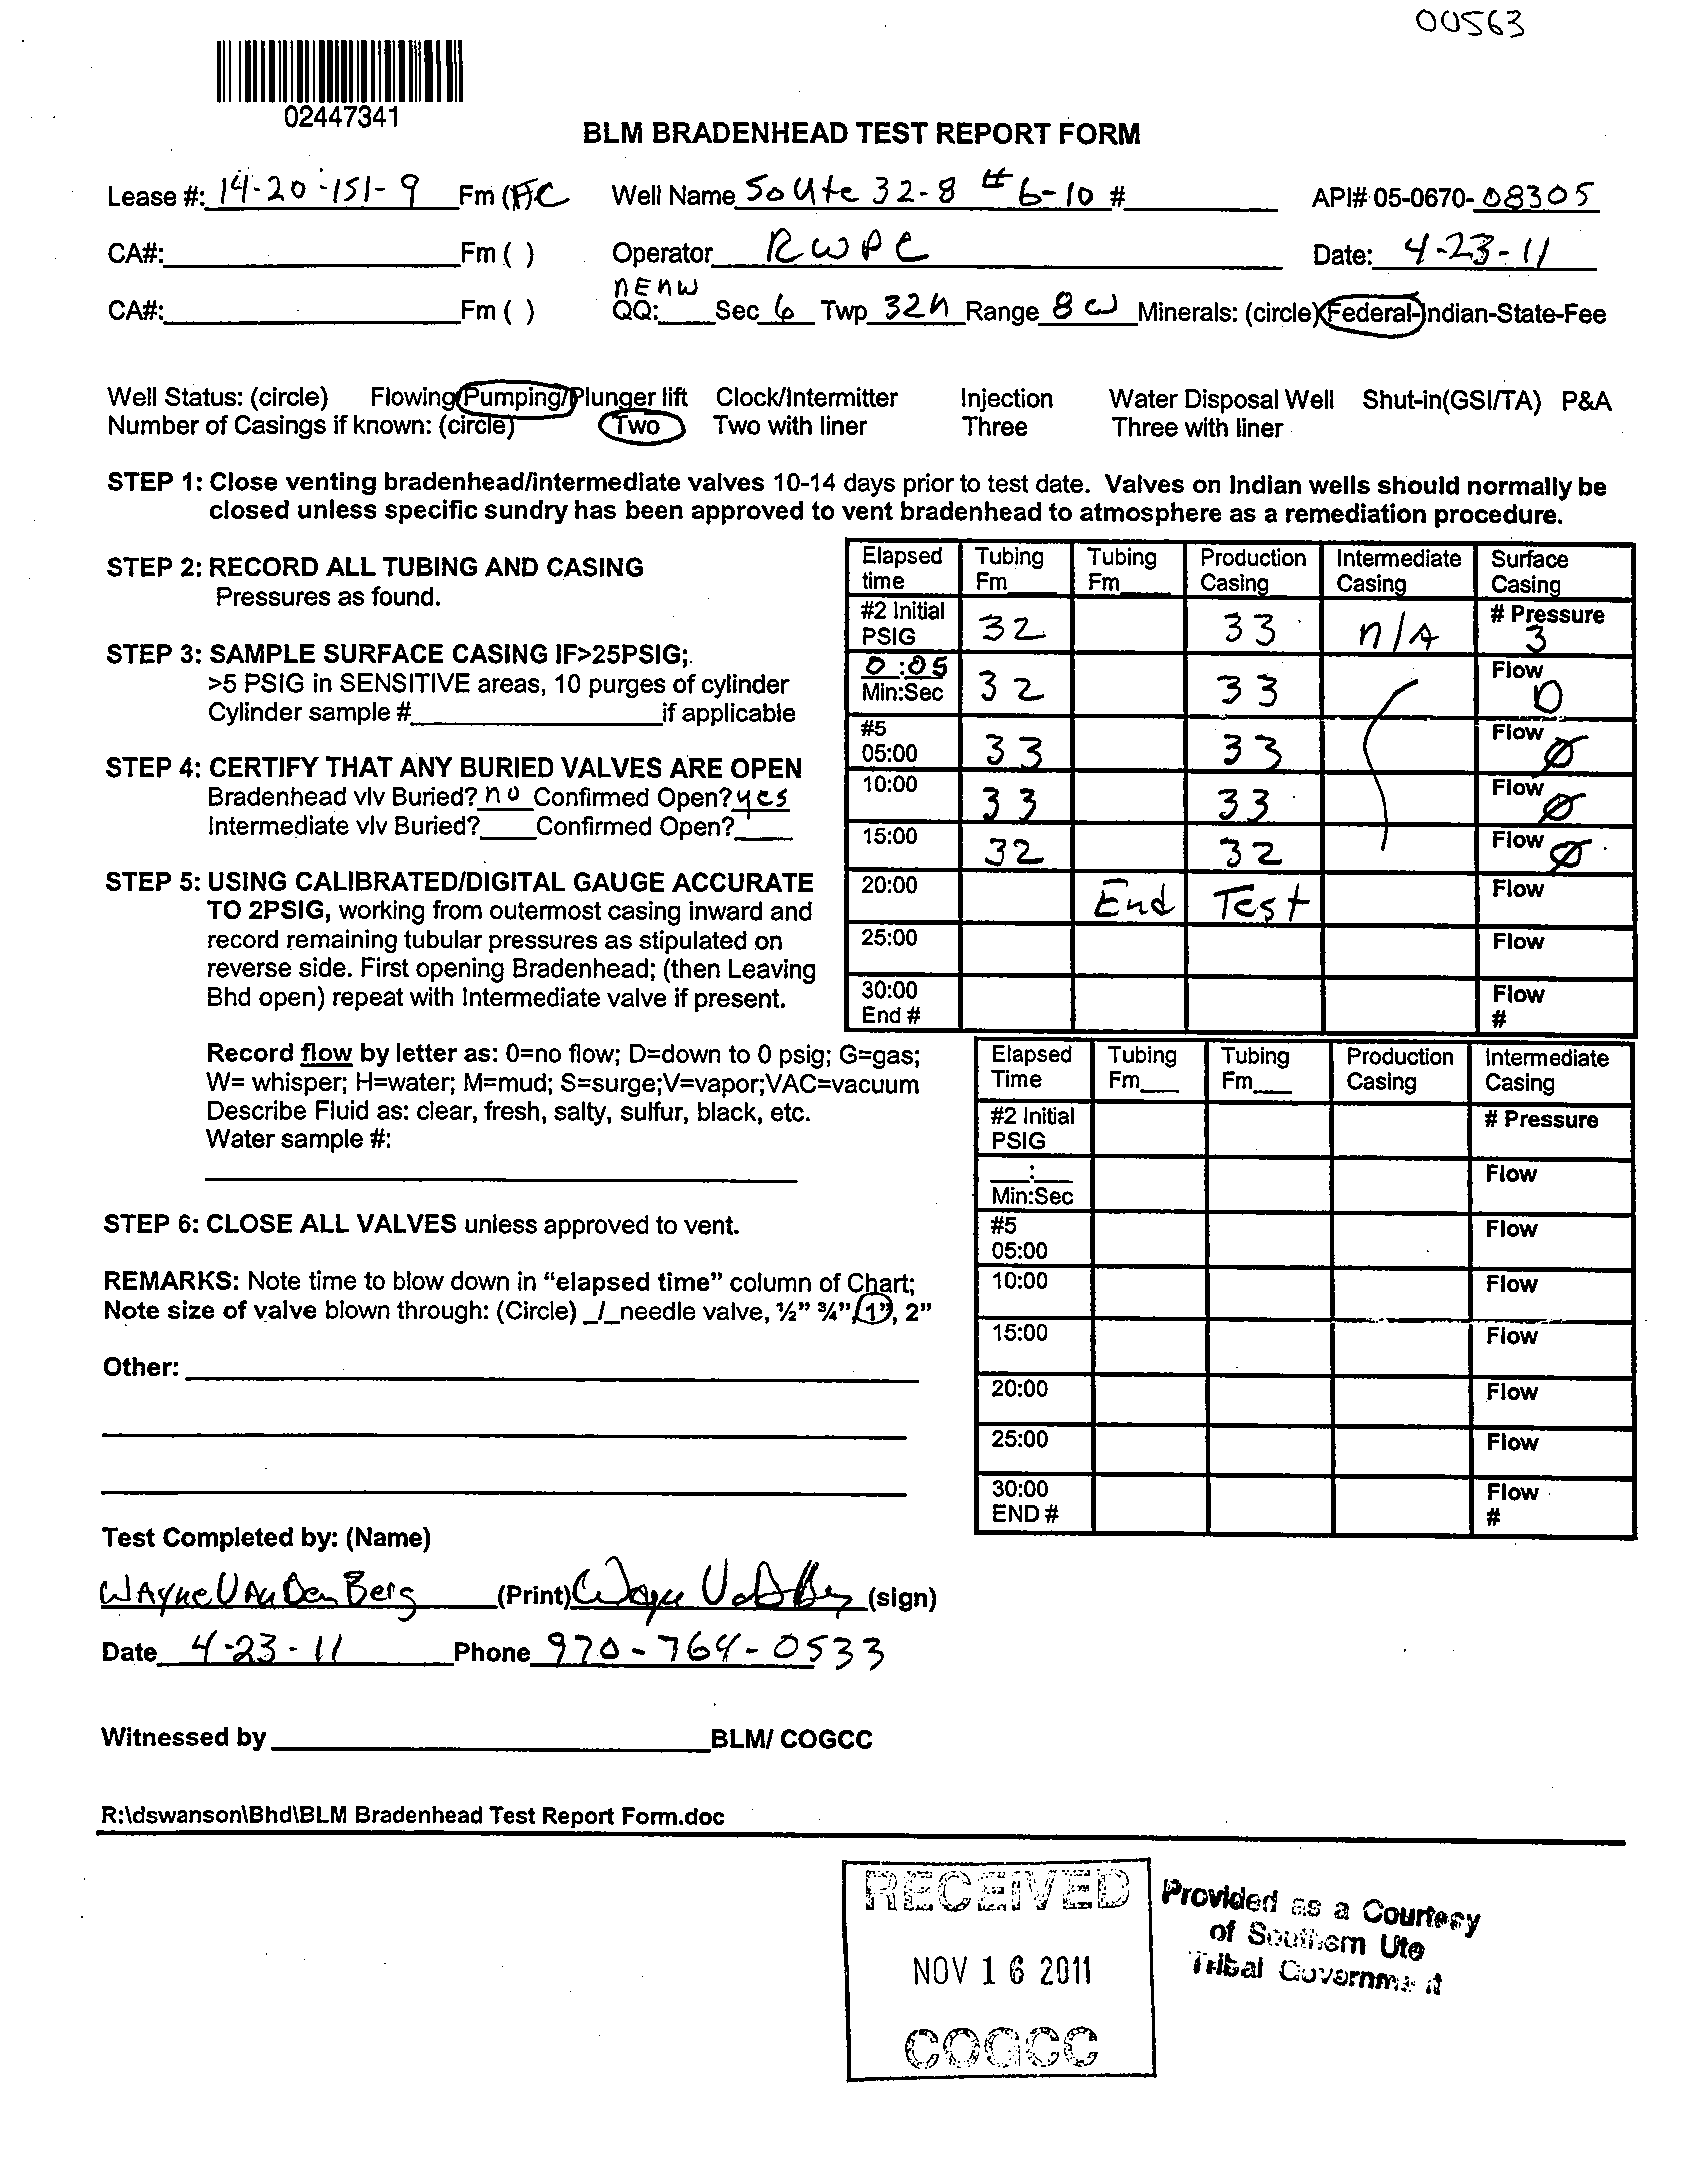

In [57]:
Image.open(paths[1514])